In [48]:
from threading import Thread, Lock, Condition
from queue import Queue
from random import randint
import numpy as np
from matplotlib import pyplot as plt
from time import sleep

# Ejercicio 1: un productor, dos consumidores, *mutex only*

In [ ]:
# Implementando con Lock
class Mutex:
    def __init__(self):
        self.esta_bloqueado = False
        self.lock = Lock()
    
    def bloquear(self):
        self.lock.acquire()
        self.esta_bloqueado = True
    
    def desbloquear(self):
        self.lock.release()
        self.esta_bloqueado = False

In [ ]:
class Productor(Thread):
    def __init__(self,buffer,mutex):
        super().__init__()
        self.buffer = buffer
        self.mutex = mutex
        self.esta_despierto = False
        
    def producir(self):
        item = randint(0,101)
        print(f'Productor: Acabo de producir {item}')
        return item
    
    def añadir_al_buffer(self,item):
        self.buffer.put(item)
        print(f'Productor: Agregué {item} al buffer')
    
    def run(self):
        while True:
            self.mutex.bloquear()
            if not self.buffer.full():
                print(f'Productor: Hay espacio para nuevos items')
                item = self.producir()
                self.añadir_al_buffer(item)
            self.mutex.desbloquear()


In [ ]:
class Consumidor(Thread):
    def __init__(self,buffer,mutex):
        super().__init__()
        self.buffer = buffer
        self.mutex = mutex
        self.esta_despierto = False
    
    def quitar_del_buffer(self):
        item = self.buffer.get()
        print(f'Consumidor: Obtuve {item} del buffer')
        return item
    
    def consumir(self,item):
        print(f'Consumidor: Consumí {item}')
    
    def run(self):
        while True:
            self.mutex.bloquear()
            if not self.buffer.empty():
                print(f'Consumidor: Hay items por consumir')
                item = self.quitar_del_buffer()
                self.consumir(item)
            self.mutex.desbloquear()



In [ ]:
mutex = Mutex()
buffer = Queue(5) # Tamaño del buffer

p = Productor(buffer,mutex)
c = Consumidor(buffer,mutex)

p.start()
c.start()

p.join()
c.join()

# Ejercicio 2: Composición de funciones

In [11]:
def g(ans):
    x = ans.pop()
    y = 3*x**2 + 2*x - 1
    ans.append(y)

In [12]:
def f(ans):
    x = ans.pop()
    y = np.sin(x)+np.cos(x)
    ans.append(y)

In [14]:
x = np.arange(-100,100,0.25)
ans = [x]
mutex = Lock()

gt = Thread(target=g,args=(ans,))
ft = Thread(target=f,args=(ans,))

gt.start()
gt.join()
ft.start()
ft.join()

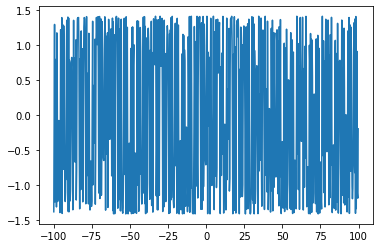

In [17]:
plt.plot(x,ans.pop())

# Ejercicio 3

Proceso de fabricación de dulces
* inicio:
    + una máquina que provee chicles
    + una máquina que provee una unidad de polvo para cubrir el chicle
   
Procesos
1. máquina que recibe el chicle y el polvo la cual cubre el chicle con el polvo 
2. máquina que recibe el bolichicle y lo envuelve
3. máquina que toma 10 bolichicles  envueltos para envasarlos en una bolsa 
-------------
Definiendo algunos nombres
* Proceso 1 : Empolvadora (chicle, polvo)->bolichicle
* Proceso 2 : Envolvedora (bolichicle) -> bolichicle envuelto
* Proceso 3 : Embalador (10 bolichicles envueltos) -> bolsa de bolichicles envueltos

Adicionalmente
* Proceso 4 : productor_chicles
* Proceso 5 : productor_polvo

In [49]:
class Empolvadora(Thread):
    def __init__(self,insumos,tiempo_produccion):
        self.insumos = insumos
        self.t = tiempo_produccion
        self.cond_recursos = Condition()
        self.encendido = False
        super().__init__()
    
    def apagar(self):
        self.encendido = False

    def hay_recursos(self):
        return self.insumos['chicles'] > 1 and self.insumos['polvo'] > 1
    
    def produce(self):
        with self.cond_recursos:
            self.cond_recursos.wait_for(self.hay_recursos)
            sleep(self.t)
            self.insumos['chicles'] -= 1
            self.insumos['polvo'] -= 1
            self.insumos['bolichicles'] += 1
            print(f'Empolvadora: Se tomó un chicle y una unidad de polvo para hacer un bolichicle')
    
    def run(self):
        self.encedido = True
        while self.encendido:
            self.produce()

In [50]:
class Envolvedora(Thread):
    def __init__(self,insumos,tiempo_produccion):
        self.insumos = insumos
        self.t = tiempo_produccion
        self.cond_recursos = Condition()
        self.encendido = False
        super().__init__()
    
    def apagar(self):
        self.encendido = False
    
    def hay_recursos(self):
        return self.insumos['bolichicles'] > 1
    
    def produce(self):
        with self.cond_recursos:
            self.cond_recursos.wait_for(self.hay_recursos)
            sleep(self.t)
            self.insumos['bolichicles'] -= 1
            self.insumos['bolichicles_env'] += 1
            print(f'Envolvedora: Se tomó un bolichicle para envolverlo')
    
    def run(self):
        self.encendido = True
        while self.encendido:
            self.produce()

In [51]:
class Embalador(Thread):
    def __init__(self,insumos,tiempo_produccion):
        self.insumos = insumos
        self.t = tiempo_produccion
        self.cond_recursos = Condition()
        self.encendido = False
        super().__init__()

    def apagar(self):
        self.encendido = False
    
    def hay_recursos(self):
        return self.insumos['bolichicles_env'] > 10
    
    def produce(self):
        with self.cond_recursos:
            self.cond_recursos.wait_for(self.hay_recursos)
            sleep(self.t)
            self.insumos['bolichicles_env'] -= 10
            self.insumos['bolsa_bolichicles'] += 1
            print(f'Embalador: Se tomó 10 bolichicles envuelos para envasarlos')
    
    def run(self):
        self.encendido = True
        while self.encendido:
            self.produce()

In [52]:
class Productor_chicles(Thread):
    def __init__(self,insumos,tiempo_produccion):
        self.insumos = insumos
        self.t = tiempo_produccion
        self.encendido = False
        super().__init__()
    
    def apagar(self):
        self.encendido = False
    
    def produce(self):
        sleep(self.t)
        self.insumos['chicles'] += 1
    
    def run(self):
        self.encendido = True
        while self.encendido:
            self.produce()

In [53]:
class Productor_polvo(Thread):
    def __init__(self,insumos,tiempo_produccion):
        self.insumos = insumos
        self.t = tiempo_produccion
        self.encendido = False
        super().__init__()
    
    def apagar(self):
        self.encendido = False
    
    def produce(self):
        sleep(self.t)
        self.insumos['polvo'] += 1
    
    def run(self):
        self.encendido = True
        while self.encendido:
            self.produce()

In [54]:
insumos = {'chicles':9,'polvo':9, 'bolichicles':0, 'bolichicles_env':0, 'bolsa_bolichicles':0}

p4 = Productor_chicles(insumos,1)
p5 = Productor_polvo(insumos,1)

p1 = Empolvadora(insumos,1)
p2 = Envolvedora(insumos,1)
p3 = Embalador(insumos,1)

p1.start()
p2.start()
p3.start()
p4.start()
p5.start()